# Black Scholes valuation methods

[*Black Scholes model WIKI*](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model). 


The purpose of this notebook is to review the most common algorithms and implement them numerically. 

## Contents
   - [European option](#sec1)
      - [Put-Call parity](#sec1.1)
   - [Numerical integration](#sec2)
   - [Monte Carlo method](#sec3)
   - [Binomial tree](#sec4)

In [6]:
from scipy.stats import norm
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial


<a id='sec1'></a>
## European option

Under the Black-Scholes (BS) model, the best method to price a vanilla European option is to use the [BS closed formula](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model).

The **BS formula** for a call is:

$$ C(t,T,S_t,K,r,\sigma) = S_t N(d_1) - K e^{-r(T-t)} N(d_2) $$

with 

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} \biggl[ \log \biggl( \frac{S_t}{K} \biggr) + \biggl(r + \frac{\sigma^2}{2} \biggr) (T-t) \biggr] \quad \mbox{and} \quad d_2 = d_1 - \sigma \sqrt{T-t} $$

where $N$ is the cumulative distribution function of a standard normal random variable.    
The formula for a put is similar and can be found in the wiki page.

The value of an option can be also computed as the discounted expectation of a future payoff in this way:

$$\begin{aligned}
 C(S_t,K,T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \int_0^{\infty} (S_T - K)^+ f(S_T|S_t) dS_T   \quad \text{(see comment below)} \\
            &= e^{-r(T-t)} \int_K^{\infty} (S_T - K) f(S_T|S_t) dS_T 
\end{aligned}$$

where $f(S_T|S_t)$ is the risk neutral transition probability of the process $\{S_u\}_{u\in [t,T]}$. This is a log-normal density function 

$$ f(S_T|S_t) = \frac{1}{S_T \sigma \sqrt{2\pi (T-t)}} \; e^{- \frac{ \biggl[\log(S_T) - \bigl(\log(S_t) + (r-\frac{1}{2} \sigma^2)(T-t) \bigr) \biggr]^2}{2\sigma^2 (T-t)}} $$


#### Comment:
In this context there is a clear abuse of notation!! Usually in statistics random variables are indicated by capital letters, and non-random variables are indicated with small letters. However, it is very common to indicate the stock price in the Black-Scholes formula with a capital letter. Here I used this notation in order to be consistent with the [wiki notation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#Notation), although I think this choice can generate misunderstandings. To summarize:    
In the function $C(S_t,K,T)$ the variables are non-random! Inside the expectation $\mathbb{E}^{\mathbb{Q}}\bigl[ (S_T - K)^+ \big| S_t \bigr]$, the variable $S_T$ is random. In the second and third lines, $S_T$ is not random and consequently the integral in $dS_T$ **is NOT** a stochastic integral.

### Let us analyze better the previous formulas



\begin{align*}
 C(S_t,K,T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] 
              - e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ K \mathbb{1}_{S_T >K} \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] 
              - e^{-r(T-t)} K \, \underbrace{\mathbb{Q}\biggl[ S_T >K \bigg| S_t \biggr]}_{N(d_2)} \\            
\end{align*}

Let us introduce the following change of measure (under the stock numeraire):

$$ \begin{aligned}
\frac{d \tilde{\mathbb{Q}} }{ d \mathbb{Q} } &= \frac{S_T}{\mathbb{E}^\mathbb{Q}[S_T]} = \frac{S_T}{S_t e^{r(T-t)}}  \\ 
                                            &= \frac{S_t e^{(r -\frac{1}{2}\sigma^2)(T-t) + \sigma W_{T-t}} }{S_t e^{r(T-t)}} \\
                                            &=   e^{ -\frac{1}{2}\sigma^2(T-t) + \sigma W_{T-t} } \quad \text{(exponential martingale)} 
\end{aligned} $$

By [Girsanov theorem](https://en.wikipedia.org/wiki/Girsanov_theorem), under $\tilde{\mathbb{Q}}$ the driving Brownian motion has the new dynamics 

$$ \tilde{W_t} = W_t - \sigma t $$

and the corresponding stock dynamics becomes

$$\begin{aligned}
 \frac{dS_t}{S_t} &= r dt + \sigma dW_t \\
                  &= (r+\sigma^2) dt + \sigma d\tilde{W}_t 
\end{aligned}$$

The first term is

$$ \begin{aligned}
 e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] =& e^{-r(T-t)} \mathbb{E}^{\tilde{\mathbb{Q}}} 
                 \biggl[ \frac{d \mathbb{Q} }{ d \tilde{\mathbb{Q}}}  S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] \\
                     =& e^{-r(T-t)} \mathbb{E}^{\tilde{\mathbb{Q}}} 
                 \biggl[ \frac{e^{r(T-t)}S_t}{S_T}  S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] \\ 
                    =& S_t \, \underbrace{\tilde{\mathbb{Q}} ( S_T > K | S_t)}_{N(d_1)}
\end{aligned}$$

We have just seen how to interpret the terms $N(d_1)$ and $N(d_2)$. These are the risk neutral probabilities of $S_T > K$ in the stock and money market numeraires respectively.

I implemented the BS closed formula in the class `BsOption`.

In [4]:
class BsOption:
    def __init__(self, S, K, T, r, sigma, q=0):
        self.S = S
        self.K = K
        self.T = T
        self.r = r 
        self.sigma = sigma
        self.q = q
        
    
    @staticmethod
    def N(x):
        return norm.cdf(x)
    
    @property
    def params(self):
        return {'S': self.S, 
                'K': self.K, 
                'T': self.T, 
                'r':self.r,
                'q':self.q,
                'sigma':self.sigma}
    
    def d1(self):
        return (np.log(self.S/self.K) + (self.r -self.q + self.sigma**2/2)*self.T) \
                                / (self.sigma*np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma*np.sqrt(self.T)
    
    def _call_value(self):
        return self.S*np.exp(-self.q*self.T)*self.N(self.d1()) - \
                    self.K*np.exp(-self.r*self.T) * self.N(self.d2())
                    
    def _put_value(self):
        return self.K*np.exp(-self.r*self.T) * self.N(-self.d2()) -\
                self.S*np.exp(-self.q*self.T)*self.N(-self.d1())
    
    def price(self, type_ = 'C'):
        if type_ == 'C':
            return self._call_value()
        if type_ == 'P':
            return self._put_value() 
        if type_ == 'B':
            return  {'call': self._call_value(), 'put': self._put_value()}
        else:
            raise ValueError('Unrecognized type')
            
        
        
        
        
if __name__ == '__main__':
    K = 100         #strike
    r = 0.1         #risk free rate
    T = 1           #maturity
    sigma = 0.2     #diffusion coefficient or volatility
    S = 100         #spot stock price
    print(BsOption(S, K, T, r, sigma).price('B'))

{'call': 13.269676584660893, 'put': 3.753418388256833}


<a id='sec1.1'></a>
### Put-Call parity

This is an important formula [wiki page](https://en.wikipedia.org/wiki/Put%E2%80%93call_parity)

$$ Call - Put = S_0 - K e^{-rT}  $$

Let us check if it works:

In [5]:
print(BsOption(S, K, T, r, sigma).price('C'))
print(BsOption(S, K, T, r, sigma).price('P') + S - K * np.exp(-r*T))

13.269676584660893
13.269676584660886


<a id='sec2'></a>
## Numerical integration

I want to play a bit with the different formulas written above.  

Let us compute the option prices by integrating the log-normal density:

In [6]:
e_ret = np.log(S) + ( r - 0.5 * sigma**2 ) * T   # expected return of the log-price
vol = sigma * np.sqrt(T)                          # standard deviation of the log-price

# log-normal density (defined above) 
def log_normal(x, e_ret, vol):
    return 1/(x*vol*np.sqrt(2*np.pi)) * np.exp(- (np.log(x) - e_ret)**2 /(2*vol**2) )

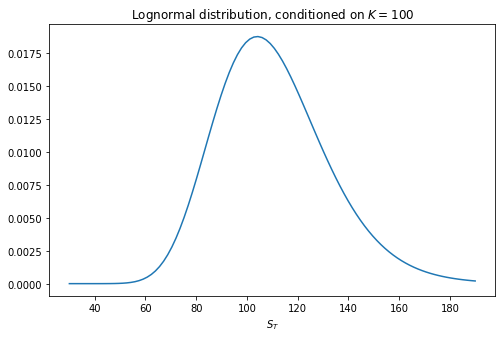

In [11]:
plt.figure(figsize=(8,5))
x = np.linspace(30,190, 100)
plt.plot(x, log_normal(x, e_ret,vol))
plt.title("Lognormal distribution, conditioned on $K=100$")
plt.xlabel("$S_T$"); plt.show()

The function `log_normal(x, e_ret, vol)` defined above, corresponds to the scipy.stats function: 
```
ss.lognorm.pdf(x, vol, scale=np.exp(e_ret) ).
```

In the next calculation, I'm going to use the scipy function.    
Let us perform the integration with the `scipy.integrate` function [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html):

In [15]:
def integrand_LN(S, strike, e_ret, vol, payoff):
    if payoff == "call":
        return (S - strike ) * ss.lognorm.pdf(S, vol, scale=np.exp(e_ret))
    elif payoff == "put":
        return (strike - S) * ss.lognorm.pdf(S, vol, scale=np.exp(e_ret))

call = quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T)
put = quad(integrand_LN, 0, K, args=(K, e_ret, vol, "put") )[0]  * np.exp(-r*T)

print("Call price: {} \nPut price: {} ".format(call,put) )

Call price: 13.269676584660926 
Put price: 3.753418388256828 


The put option payoff $(K-S_T)^+$ is positive for $S_T < K$.    
- In the call case, the integration is from $K$ to $\infty$.
- In the put case, the integration is from $0$ to $K$.

What if we use the change of measure proposed above?  In this way the integrations are simpler.    
Let us compute $\tilde{\mathbb{Q}}( S_T > K )$ and $\mathbb{Q}( S_T > K )$.

In [17]:
e_ret_1 = np.log(S) + ( r + 0.5 * sigma**2 ) * T  # expected return of the log-price under the new measure

Q1 = quad(lambda S: ss.lognorm.pdf(S, vol, scale=np.exp(e_ret_1)), K, np.inf )[0]
print("Risk neutral probability under stock numeraire,\n Q1 =", Q1)
Q2 = quad(lambda S: ss.lognorm.pdf(S, vol, scale=np.exp(e_ret)), K, np.inf )[0]
print("Risk neutral probability under money market numeraire,\n Q2 =", Q2)

print("BS call price: ", S * Q1 - K* np.exp(-r*T) *Q2  )

Risk neutral probability under stock numeraire,
 Q1 = 0.7257468822499274
Risk neutral probability under money market numeraire,
 Q2 = 0.6554217416103069
BS call price:  13.269676584662555


It is quite common to compute the Black-Scholes formula using $N(d_1)$ and $N(d_2)$.   
The reason is that the cumulative function of the standard Normal distribution is more accessible (I guess).

For completeness, let me recall that if $X_T$ is a Normal random variable, then $S_T = S_0 e^{X_T}$ is Log-Normal. Therefore we have:

$$ \mathbb{Q}( S_T > K ) = \mathbb{Q}\biggl( S_0 e^{X_T} > K \biggr) = \mathbb{Q}\biggl( X_T > \log \frac{K}{S_0} \biggr). $$

This permits to use the Normal cumulative function.

<a id='sec3'></a>
## Monte Carlo method

I'm going to simulate the random variables: 

$$ S_T^i = S_0 e^{(r -\frac{1}{2}\sigma^2)T + \sigma W_{T}^i} $$

for $1 \leq i \leq N$.    
Then use the approximation for a call option:

$$ \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_0 \biggr] \; 
\approx \; \frac{1}{N} \sum_{i=1}^N (S_T^i - K)^+
$$

For a put option I use this payoff $(K - S_T )^+$ inside the expectation.

In [22]:
np.random.seed(seed=44)  # seed for random number generation
N = 10000000  # Number of random variables

W = ss.norm.rvs( (r-0.5*sigma**2)*T , np.sqrt(T)*sigma, N)
S_T = S * np.exp(W)

call = np.mean( np.exp(-r*T) * np.maximum(S_T-K,0) )
put = np.mean( np.exp(-r*T) * np.maximum(K-S_T,0) )
call_err = ss.sem( np.exp(-r*T) * np.maximum(S_T-K,0) )  # standard error
put_err = ss.sem( np.exp(-r*T) * np.maximum(K-S_T,0) )   # standard error

In [23]:
print("Call price: {}, with error: {}".format(call, call_err))
print("Put price: {}, with error: {}".format(put, put_err))

Call price: 13.26333800663666, with error: 0.005093638687208466
Put price: 3.7553894006350084, with error: 0.002214066662789331


<a id='sec4'></a>
## Binomial tree


Of course I cannot forget about the Binomial model!
This is a simple but very powerful numerical method!

If you are not familiar with this model, have a look at the [wiki page](https://en.wikipedia.org/wiki/Binomial_options_pricing_model).      
Here I present an efficient implementation:

In [33]:
N = 15000              # number of periods or number of time steps  
payoff = "call"        # payoff 

dT = float(T) / N                             # Delta t
u = np.exp(sigma * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

V = np.zeros(N+1)                             # initialize the price vector
S_T = np.array( [(S * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

a = np.exp(r * dT)    # risk free compounded return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability   

if payoff =="call":
    V[:] = np.maximum(S_T-K, 0.0)
else:
    V[:] = np.maximum(K-S_T, 0.0)

for i in range(N-1, -1, -1):
    V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
        
print("BS Tree Price: ", V[0])

BS Tree Price:  13.269537371978052
